
## Task 2
Create a PowerPoint presentation wihch outlines the approach we will be taking to identify which of the 1000 customers Sprocket Central Pty Ltd should target, based on this dataset. Explain the three phases:  Data Exploration; Model Development and Interpretation.


Sprocket Central Pty Ltd has given us a new list of 1000 potential customers with their demographics and attributes. However, these customers do not have prior transaction history with the organisation. 

The marketing team at Sprocket Central Pty Ltd is sure that, if correctly analysed, the data would reveal useful customer insights which could help optimise resource allocation for targeted marketing. Hence, improve performance by focusing on high value customers.



For context, Sprocket Central Pty Ltd is a long-standing KPMG client whom specialises in high-quality bikes and accessible cycling accessories to riders. Their marketing team is looking to boost business by analysing their existing customer dataset to determine customer trends and behaviour. 

Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, please recommend which of these 1000 new customers should be targeted to drive the most value for the organisation. 

In building this recommendation, we need to start with a PowerPoint presentation which outlines the approach which we will be taking. The client has agreed on a 3 week scope with the following 3 phases as follows - Data Exploration; Model Development and Interpretation.

Prepare a detailed approach for completing the analysis including activities – i.e. understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting. This detailed plan needs to be presented to the client to get a sign-off. Please advise what steps you would take. 

Please ensure your PowerPoint presentation includes a detailed approach for our strategy behind each of the 3 phases including activities involved in each - i.e. understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting. This detailed plan needs to be presented to the client to get a sign-off.

--
Tips: Raw data fields may be transformed into other calculated fields for modelling purposes (i.e. converting D.O.B to age or age groups).  Tips: You may source external data from the ABS / Census to add additional variables that may help support your model. 

### Objectives

##### 1) Find high value customers
##### 2) Determine customer trends and behaviour
##### 3) which of these 1000 new customers should be targeted to drive the most value for the organisation
##### 4) Data Exploration; Model Development and Interpretation- PPT on the project approach(understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting)

##### can customers be clustered based on their value?


In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 
import matplotlib 

In [2]:
excelFile = pd.ExcelFile("newData.xlsx")       

In [3]:
Transactions = pd.read_excel(excelFile, 'Transactions', skiprows=[0]) 
CustomerDemographic = pd.read_excel(excelFile,'CustomerDemographic', skiprows=[0]) 
CustomerAddress = pd.read_excel(excelFile, 'CustomerAddress', skiprows=[0])
newCustomers = pd.read_excel(excelFile,"NewCustomerList", skiprows = [0])
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",None) 

In [4]:
data = pd.merge(CustomerDemographic,CustomerAddress, on="customer_id")  
data = pd.merge(Transactions,data, on="customer_id") 
data.to_csv("customerData.csv") 

In [5]:
data.head(5)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,37659.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,478.16,298.72,40487.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6
3,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,Lauree,O'Donnell,Female,89,1979-02-04,Clinical Specialist,Health,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,10.0,4 Shopko Circle,2196,NSW,Australia,5
4,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,medium,1129.13,677.48,40649.0,Lauree,O'Donnell,Female,89,1979-02-04,Clinical Specialist,Health,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,10.0,4 Shopko Circle,2196,NSW,Australia,5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19968 entries, 0 to 19967
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19968 non-null  int64         
 1   product_id                           19968 non-null  int64         
 2   customer_id                          19968 non-null  int64         
 3   transaction_date                     19968 non-null  datetime64[ns]
 4   online_order                         19609 non-null  float64       
 5   order_status                         19968 non-null  object        
 6   brand                                19773 non-null  object        
 7   product_line                         19773 non-null  object        
 8   product_class                        19773 non-null  object        
 9   product_size                         19773 non-null  object        
 10  list_price

### Task2
#### list_price : The list price, also known as the manufacturer's suggested retail price (MSRP), or the recommended retail price (RRP)
#### standard_cost :Standard costs are estimates of the actual costs in a company's production process, because actual costs cannot be known in advance.

#### clustering customers by the buisness value they generate

In [7]:
data["profitability"] = data.apply(lambda x: x["list_price"] - x["standard_cost"], axis = 1)

In [8]:
data.groupby(["customer_id"])["profitability"].sum().sort_values(ascending = False)       # 3489

customer_id
941     11668.95
2637    11222.65
1460    10787.60
1558    10640.30
729     10497.78
3326    10422.04
322     10341.57
2770    10028.80
1597     9739.46
1887     9695.59
195      9633.41
363      9458.17
1482     9269.16
936      9244.90
2046     9188.77
2788     9061.47
3232     8903.62
832      8868.62
2912     8835.01
1866     8834.60
1559     8624.72
999      8611.95
213      8544.50
1140     8533.23
3117     8531.16
1625     8499.59
2492     8437.43
3048     8379.96
473      8364.66
2860     8357.70
1329     8352.16
841      8330.09
347      8326.37
3460     8321.81
1991     8256.08
2379     8252.73
3242     8252.69
2695     8243.81
2762     8237.49
1033     8220.05
733      8210.30
2659     8143.93
1076     8104.54
1579     8102.62
344      8101.26
2999     8095.20
1722     8086.75
445      8081.86
1808     7965.28
2874     7910.31
2733     7827.41
2464     7817.10
1475     7812.17
2458     7756.79
753      7727.17
1503     7693.78
438      7692.39
3212     7666.65
15

In [9]:
data.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,address,postcode,state,country,property_valuation,profitability
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6,17.87
1,11065,1,2950,2017-10-16,0.0,Approved,Giant Bicycles,Standard,medium,medium,1403.50,954.82,37659.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6,448.68
2,18923,62,2950,2017-04-26,0.0,Approved,Solex,Standard,medium,medium,478.16,298.72,40487.0,Kristos,Anthony,Male,19,1955-01-11,Software Engineer I,Financial Services,Mass Customer,N,ã»(ï¿£âï¿£)ã»:*:,Yes,10.0,984 Hoepker Court,3064,VIC,Australia,6,179.44
3,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,Lauree,O'Donnell,Female,89,1979-02-04,Clinical Specialist,Health,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,10.0,4 Shopko Circle,2196,NSW,Australia,5,1702.55
4,6862,4,3120,2017-10-05,0.0,Approved,Giant Bicycles,Standard,high,medium,1129.13,677.48,40649.0,Lauree,O'Donnell,Female,89,1979-02-04,Clinical Specialist,Health,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,10.0,4 Shopko Circle,2196,NSW,Australia,5,451.65


In [10]:
import DataReporter
%run -i DataReporter.py

In [11]:
report = Report(data)
report.eda()

 Size of the data set is (19968, 31) 


column:  transaction_id
Number of Unique values: 19968
min = 1, max = 20000, range = 19999

column:  product_id
Number of Unique values: 101
min = 0, max = 100, range = 100

column:  customer_id
Number of Unique values: 3489
min = 1, max = 3500, range = 3499

column:  transaction_date
Number of Unique values: 364
min = 2017-01-01 00:00:00, max = 2017-12-30 00:00:00, range = 363 days 00:00:00

column:  online_order
Number of Unique values: 3
min = 0.0, max = 1.0, range = 1.0
List
 [ 0.  1. nan]

column:  order_status
Number of Unique values: 2
List
 ['Approved' 'Cancelled']

column:  brand
Number of Unique values: 7
List
 ['Solex' 'Giant Bicycles' 'Trek Bicycles' 'WeareA2B' 'OHM Cycles'
 'Norco Bicycles' nan]

column:  product_line
Number of Unique values: 5
List
 ['Standard' 'Road' 'Touring' 'Mountain' nan]

column:  product_class
Number of Unique values: 4
List
 ['medium' 'high' 'low' nan]

column:  product_size
Number of Unique values: 4
List
 

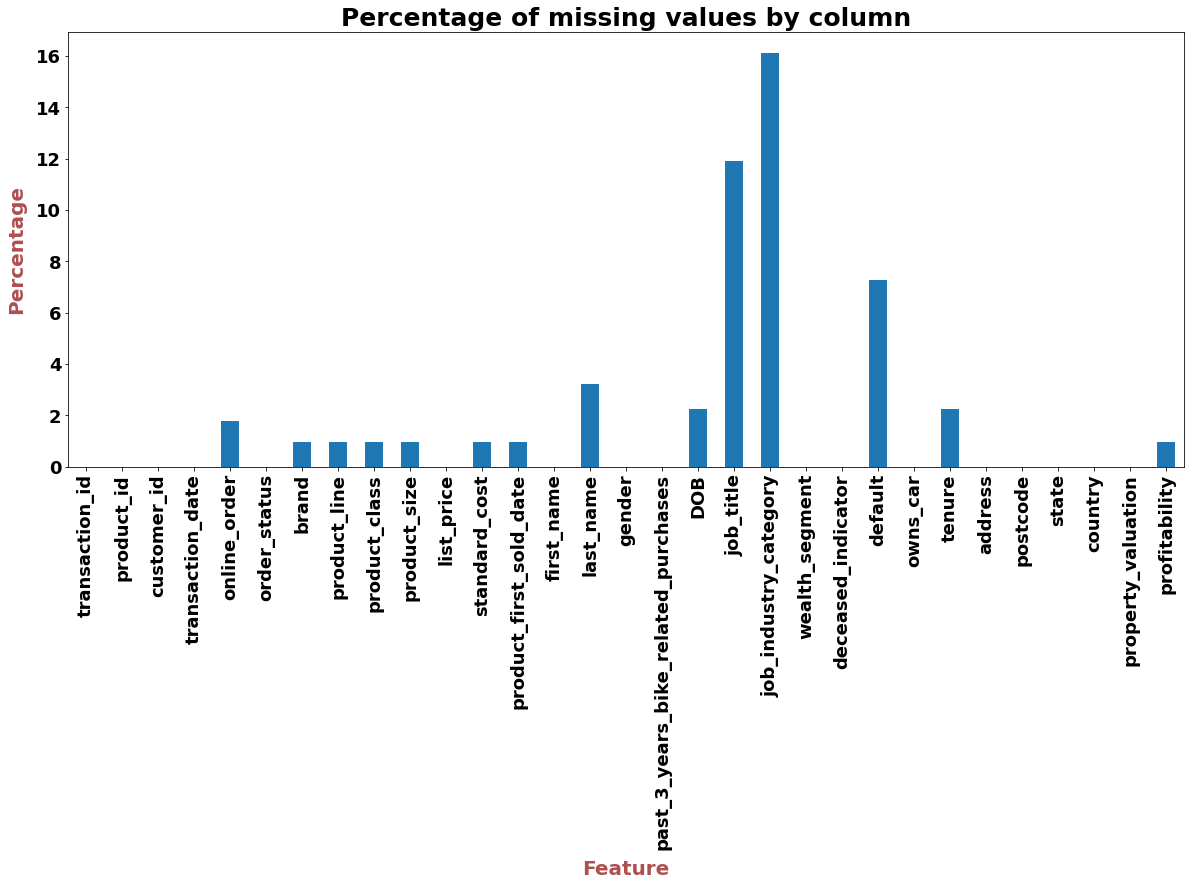

In [12]:
report.missing()

In [13]:
# custFreq = data.loc[:,"customer_id"].value_counts()         # [2476]
# data["custFreq"] = 0

ValueError: num must be 1 <= num <= 3, not 4

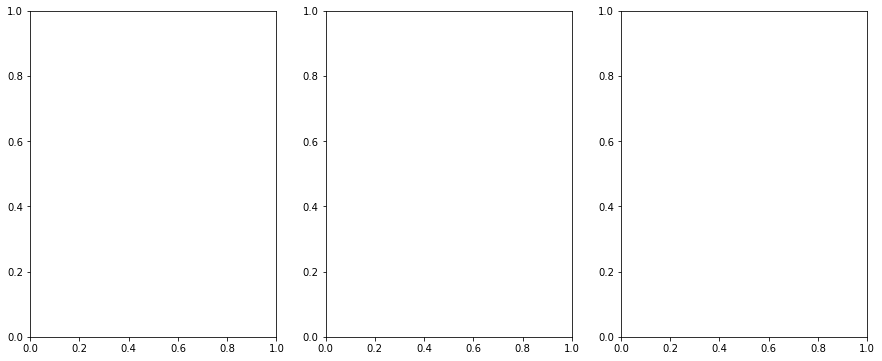

In [21]:
plt.figure(1,figsize=(15,6))    
i = 0
for column in data.columns:
    i=i+1
    plt.subplot(1,3,i)
    